# Hydrogel-Cell Interaction Test Case

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d

## Input information

In [2]:
############################# change inputs here #################################
# Data file name
datadir = ''
smoothed = ''
dilated = ''
shapename = 'noise'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3; nu0 = 0.499;
r0 = 5;           # microns

# Arbitrary force field (opposite forces)
pF = 1            # force magnitude (Pa)
Tf_err = 0.01     # Threshold below which considered traction-free, unit in mu (100Pa)

# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
init_guess_type = 'true' #'ur-only' or 'true'

# regularizations
myalpha = 1     # traction magnitude
mybeta  = 10  # coefficient magnitude

# program switches
plot_figure = False
myord = 1; # myord: p-norm order (1-mean value)

# minimization settings
N_period = 5
maxiter_per_period = 5
CG_gtol = 1e-5

minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'disp': True, 'gtol': CG_gtol}

# dump files for minimization
savename = shapename #+('_a%.0e_b%.0e'%(myalpha, mybeta))+('_lmax%d'%lJmax)+smoothed+dilated

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join('..', 'shelastic', 'default_modes')

#################################################################################
mu = 1.; nu = nu0;
Dmat = generate_submat(loadmat(os.path.join(coeff_dir, 'Umodes.mat')),
                       mu, nu, lKmax, lJmax, shtype=shtype, verbose=True).tocsc()
Cmat = generate_submat(loadmat(os.path.join(coeff_dir, 'Tmodes.mat')),
                       mu, nu, lKmax, lJmax, shtype=shtype, verbose=True).tocsc()

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


## Define arbitrary force field

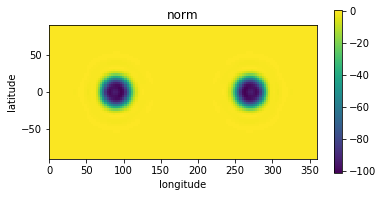

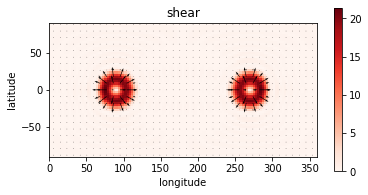

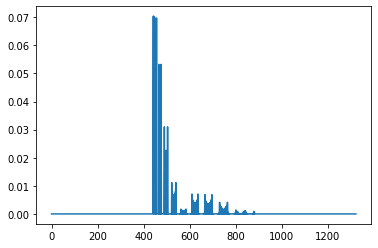

In [3]:
N = GLQCartCoord(lJmax); X0 = N*r0;

# Select contact region
pLeft = np.array([0, -r0, 0]); pRight = np.array([0, r0, 0]);
rcut = r0/3; mag = 4; dilation = 2;
distLeft = rcut - np.linalg.norm(X0 - pLeft.reshape(1, 1, 3), axis=-1)
distRight= rcut - np.linalg.norm(X0 - pRight.reshape(1, 1, 3),axis=-1)
regionLeft = 1/(1 + np.exp(-distLeft*mag))
regionRight = 1/(1 + np.exp(-distRight*mag))

# Add opposing forces on both sides
T_usr_mesh_init = np.zeros_like(X0, dtype=np.complex)
F_mesh = np.zeros_like(X0, dtype=np.complex)
F_mesh[..., 1] = (pF+0j)*regionLeft - (pF+0j)*regionRight
T_usr_mesh_init = F_mesh

# decompose the force field into spherical harmonics
T_usr_vec = SHmesh2Vec(T_usr_mesh_init)
fig, axs = visSHVec(T_usr_vec*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))#, n_vrange=(-10,0))

fig, ax = plt.subplots(1, 1)
ax.plot(np.abs(T_usr_vec))
plt.show()

T_usr_mesh = SHVec2mesh(T_usr_vec, lmax=lJmax, SphCoord=False, Complex=True)
T_usr_mesh_sph = SHVec2mesh(T_usr_vec, lmax=lJmax, SphCoord=True, Complex=True)

In [4]:
Uvec = Tvec2Uvec(T_usr_vec, Cmat, Dmat)

umesh_fine_scaled = SHVec2mesh(Uvec, lmax=lmax_plot, SphCoord=False, Complex=True)
umesh_fine = SHVec2mesh(Uvec*r0, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(T_usr_vec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

if plot_figure:
    fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, r0=r0, show=False, 
                      elevation=15, azimuth=45, surface=True, figsize=plt.figaspect(1))
    ax.set_xlim(-r0, r0)
    ax.set_ylim(-r0, r0)
    ax.set_zlim(-r0, r0)
    plt.show()

#### Define and visualize the traction-free region

In [5]:
print(np.abs(T_usr_vec - Uvec2Tvec(Uvec, Cmat, Dmat)).max())

latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
LONS, LATS = np.meshgrid(lonsdeg, latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)*r0
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
VX0 = np.stack([X,Y,Z], axis=-1)
print(VX0.shape)

Vp = (VX0 + umesh_fine).reshape(-1, 3)
TcLeft = (rcut+dilation) > np.linalg.norm(VX0 - pLeft.reshape(1, 1, 3), axis=-1)
TcRight= (rcut+dilation) > np.linalg.norm(VX0 - pRight.reshape(1, 1, 3), axis=-1)
TfRegion = np.logical_not(np.logical_or(TcLeft, TcRight))

if plot_figure:
    %matplotlib notebook
    fig, axs = visSHVec(T_usr_vec*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                       config_quiver=(2, 3, 'k', 1000), lonshift=180, figsize=(6,3), n_vrange=(-10,0))
    axs[0].contour(LONS, LATS, TfRegion, [0.5,], colors='k', linewidths=1)
    axs[1].contour(LONS, LATS, TfRegion, [0.5,], colors='k', linewidths=1)
    plt.show()

Tfv = TfRegion.flatten()

5.851821443102548e-12
(61, 121, 3)


Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

Conversion between complex and real spherical harmonics, for $m>0$

$$
f_{lm} = \left[f_l^m+(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_{l-m}=i\left[f_l^m-(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_l^m = (f_{lm}-if_{l-m})/\sqrt{2}\\
f_l^{-m} = (-1)^m(f_{lm}+if_{l-m})/\sqrt{2}
$$

for $m=0$:

$$
f_{l0} = f_l^0
$$


## 1. Obtain the initial guess

First thing to try is assuming that the deformation only happens on $r$-direction.

In [6]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### Develop the interpolation function for $u_r(\theta,\varphi)$ from data

In [7]:
urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax+10)
print(chi2)

ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
urgrid_interp = ucoeff_interp.expand('GLQ')

lats = urgrid_interp.lats(); lons = urgrid_interp.lons();
lats_circular = np.hstack(([90.], lats, [-90.]))
lons_circular = np.append(lons, 360)
LONS, LATS = np.meshgrid(lons_circular, lats_circular)
xmesh = urgrid_interp.to_array().copy()
fpoints = np.zeros_like(LONS)
fpoints[1:-1, :-1] = xmesh
fpoints[0, :] = np.mean(xmesh[0,:], axis=0)  # not exact !
fpoints[-1, :] = np.mean(xmesh[-1,:], axis=0)  # not exact !
fpoints[1:-1, -1] = xmesh[:, 0]
print(LATS.shape, LONS.shape, fpoints.shape)
print(lats_circular.shape, lons_circular.shape)
f_interp = RectBivariateSpline(lats_circular[::-1], lons_circular, fpoints[::-1, ], kx=1, ky=1)

## Test the interpolation algorithm

tic = time.time()
ur_interp = f_interp.ev(Vlat, Vlon)
toc = time.time()
print(f_interp.get_coeffs().shape)
print(ur_interp.shape, toc-tic)
print(ur_interp - ur)

7.914290312001283e-08
(33, 62) (33, 62) (33, 62)
(33,) (62,)
(2046,)
(7381,) 0.0009920597076416016
[-5.46393538e-05 -5.50770108e-05 -5.52468345e-05 ... -5.61872173e-05
 -5.52468345e-05 -5.50770107e-05]


### 2.3 Target function including shape and traction

In [8]:
# Define weights and traction free region
dist2mat = np.linalg.norm((X0[..., np.newaxis, :] - Vp)/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
if dilated == '_softedge':
    isTfv = mask[arg_list_x]
else:
    isTfv = Tfv[arg_list_x]

print(isTfv.shape)

(21, 41)


We use the solution we obtained from Section 1 `Uvec_real` for the testing:

In [9]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
# print(latsdeg, lonsdeg)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0shear = np.stack([lat0, lon0], axis=-1)

def usurf2vec(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp):
    x_surf = X0surf + u_surf.reshape(X0surf.shape)
    lat_x = x_surf[..., 0]; lon_x = x_surf[..., 1];
    Theta_x = np.deg2rad(90 - lat_x); Phi_x = np.deg2rad(lon_x);
    R_x = f_interp.ev(lat_x, lon_x)+1
    x = np.stack(SphCoord_to_CartCoord(R_x, Theta_x, Phi_x), axis=-1)
    umesh = x - X0
    Uvec  = SHmesh2Vec(umesh, lmax=lJmax)
    aK    = spsolve(Dmat, Uvec.T)
    Tvec  = Cmat.dot(aK)
    return Uvec, aK, Tvec

def usurf2Eel(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp):
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    return np.vdot(Uvec, Tvec).real*2*np.pi

def usurf2Tres(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp, isTfv=isTfv, lmax=lJmax, 
               lat_weights=None, vert_weight=1, norm_order=1):
    if lat_weights is None:
        lat_weights = np.ones((lmax+1, 2*lmax+1))
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    if isTfv.dtype == np.bool:
        tvalues = np.sum((tmesh[isTfv, :]*vert_weight)**2, axis=-1)
        lat_weights_value = lat_weights[isTfv]**2
    else:
        tvalues = np.sum((tmesh * vert_weight)**2, axis=-1)*isTfv
        lat_weights_value = lat_weights**2
    if norm_order > 1:
        Tdist = np.linalg.norm(tvalues*lat_weights_value, ord=norm_order)
    else:
        Tdist = np.mean(tvalues*lat_weights_value)
    return Tdist

def usurf2dr(u_surf, beta=1, X0surf=X0shear, X0=X0/r0, f_interp=f_interp, isTfv=isTfv, lmax=lJmax, 
             lat_weights=None, vert_weight=1, norm_order=1):
    if lat_weights is None:
        lat_weights = np.ones((lmax+1, 2*lmax+1))
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    if isTfv.dtype == np.bool:
        tvalues = np.sum((tmesh[isTfv, :]*vert_weight)**2, axis=-1)
        lat_weights_value = lat_weights[isTfv]**2
    else:
        tvalues = np.sum((tmesh * vert_weight)**2, axis=-1)*isTfv
        lat_weights_value = lat_weights**2
    if norm_order > 1:
        Tdist = np.linalg.norm(tvalues*lat_weights_value, ord=norm_order)
    else:
        Tdist = np.mean(tvalues*lat_weights_value)
    Eel = np.vdot(Uvec, Tvec).real*2*np.pi
    return Tdist + beta*Eel

In [11]:
import glob
filelist = glob.glob('AK_noise_b%.0e_??.npz'%mybeta)
nfile = len(filelist)
# init_guess_type = 'true'
if nfile > 0:
    u0_surf = np.load('AK_noise_b%.0e_%02d.npz'%(mybeta, nfile-1))['u_surf']
# elif init_guess_type == 'true':
#     u0_vec = Uvec.copy()
#     x0mesh = SHVec2mesh(u0_vec, lmax=lJmax, SphCoord=False, Complex=True) + X0/r0
#     r0surf, t0surf, p0surf = CartCoord_to_SphCoord(x0mesh[..., 0], x0mesh[..., 1], x0mesh[..., 2])
#     lat0surf = 90 - np.rad2deg(t0surf); lon0surf = np.rad2deg(p0surf);
#     u0_surf = np.stack([lat0surf, lon0surf], axis=-1) - X0shear
# elif init_guess_type == 'ur-only':
#     u0_surf = np.zeros_like(X0shear)
#print(u0_surf)#, X0/r0)
print('Traction residual: %.4e Pa'%(usurf2Tres(u0_surf)*mu0))
print('Elastic energy: %.4e pJ'%(usurf2Eel(u0_surf)*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(usurf2Tres(u0_surf), usurf2Eel(u0_surf)))

U0vec, aK, T0vec = usurf2vec(u0_surf)

Traction residual: 5.3561e-01 Pa
Elastic energy: 5.3000e-04 pJ
funval: 5.3561e-03 4.2400e-02


In [12]:
u_surf = u0_surf.copy()

print('Traction residual: %.4e Pa'%(usurf2Tres(u_surf)*mu0))
print('Elastic energy: %.4e pJ'%(usurf2Eel(u_surf)*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(usurf2Tres(u_surf), usurf2Eel(u_surf)))

Traction residual: 5.3561e-01 Pa
Elastic energy: 5.3000e-04 pJ
funval: 5.3561e-03 4.2400e-02


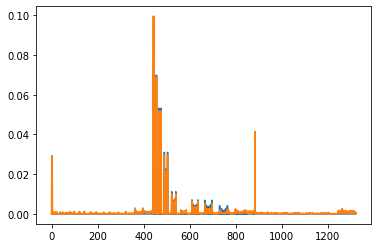

Displacement in Spherical Coordinates...


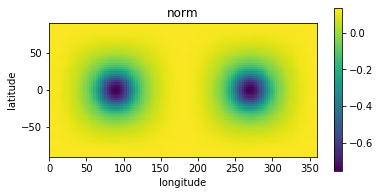

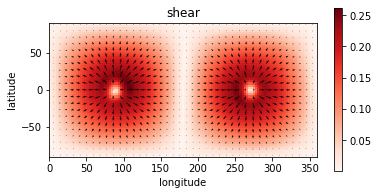

Traction in Spherical Coordinates...


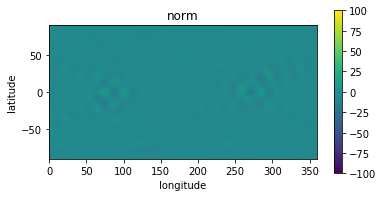

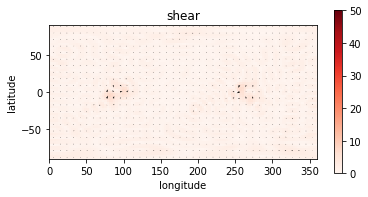

In [13]:
Usurfvec, aK, Tsurfvec = usurf2vec(u_surf)

fig, ax = plt.subplots()
ax.plot(np.abs(T_usr_vec))
ax.plot(np.abs(Tsurfvec))
plt.show()

xmesh_ref = SHVec2mesh(Uvec, lmax=lJmax, SphCoord=False, Complex=True) + X0/r0
x_sph_ref = CartCoord_to_SphCoord(xmesh_ref[..., 0], xmesh_ref[..., 1], xmesh_ref[..., 2])
u_ref = np.stack([90 - np.rad2deg(x_sph_ref[1]), np.rad2deg(x_sph_ref[2])], axis=-1) - X0shear
Uvec_ref, aK_ref, Tvec_ref = usurf2vec(u_ref)

print('Displacement in Spherical Coordinates...')
fig, ax = visSHVec(Usurfvec*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, #s_vrange=(0,0.01),
                   config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
print('Traction in Spherical Coordinates...')
fig, ax = visSHVec((Tsurfvec-Tvec_ref)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                   n_vrange=(-100, 100), s_vrange=(0, 50),
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))

Visualize the shape in 3D...


<IPython.core.display.Javascript object>


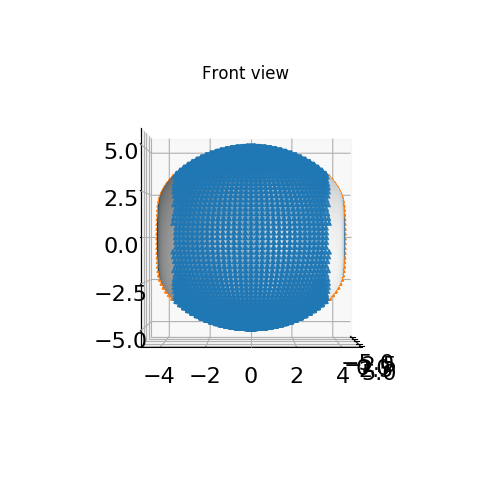

In [14]:
%matplotlib notebook
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=0, 
                  surface=True, figsize=plt.figaspect(1))

# reference data
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Front view')
if False: #savefig:
    plt.tight_layout(); plt.savefig(savename+'_front.png', transparent=True)
plt.show()